# ✅ Fast ResNet-18 (Lite) on CIFAR-10 — TensorFlow/Keras

This notebook is designed for **classroom demos**: it trains a small ResNet quickly (minutes, not hours).


## What you will learn
1. Load CIFAR-10 and prepare data for training.
2. Build a **ResNet-style** model using **residual (skip) connections**.
3. Understand why we use mini-batches, augmentation, and normalization.
4. Train efficiently using:
   - **Learning-rate scheduler (cosine decay)**
   - **SGD + momentum**
   
   - Optional **mixed precision** for GPU speed

## Why this version is “fast”
- It is **ResNet-18-like**, but with fewer channels (a *width multiplier*).
- Augmentation is done using Keras layers (fast on GPU).
- You can limit training with `LIMIT_STEPS_PER_EPOCH` for classroom demos.


## 1) Imports + Reproducibility (so results are repeatable)

In [1]:
# Python standard libraries
import os
import random

# Numerical computing
import numpy as np

# Deep learning
import tensorflow as tf

# Plotting (to visualize learning curves)
import matplotlib.pyplot as plt

print('TensorFlow version:', tf.__version__)

# ------------------------------------------------------------
# Reproducibility:
# Setting seeds helps us get similar results when we rerun the code.
# Note: exact reproducibility is not guaranteed on GPU due to nondeterminism,
# but this improves consistency.
# ------------------------------------------------------------
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ------------------------------------------------------------
# (Optional) Mixed Precision:
# On many NVIDIA GPUs, float16 operations are faster.
# If you are on CPU-only, you can comment this out.
# ------------------------------------------------------------
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    print('Mixed precision policy:', mixed_precision.global_policy())
except Exception as e:
    print('Mixed precision not enabled:', e)

# Show available devices (CPU/GPU)
print('Available GPUs:', tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
Mixed precision policy: <DTypePolicy "mixed_float16">
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2) Load CIFAR-10 + Normalize Images

In [2]:
# ------------------------------------------------------------
# CIFAR-10 dataset:
# - 50,000 training images
# - 10,000 test images
# - each image is 32x32 with 3 color channels (RGB)
# - 10 classes
# ------------------------------------------------------------
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

NUM_CLASSES = 10
INPUT_SHAPE = (32, 32, 3)

# y_train and y_test come as shape (N, 1). Convert to shape (N,)
y_train = y_train.squeeze().astype('int32')
y_test  = y_test.squeeze().astype('int32')

# ------------------------------------------------------------
# Normalize images:
# Scale pixels from [0,255] to [0,1]
# ------------------------------------------------------------
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0

print('Train images:', x_train.shape)
print('Train labels:', y_train.shape)
print('Test images :', x_test.shape)
print('Test labels :', y_test.shape)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Train images: (50000, 32, 32, 3)
Train labels: (50000,)
Test images : (10000, 32, 32, 3)
Test labels : (10000,)


### (Optional) Visualize a few training images

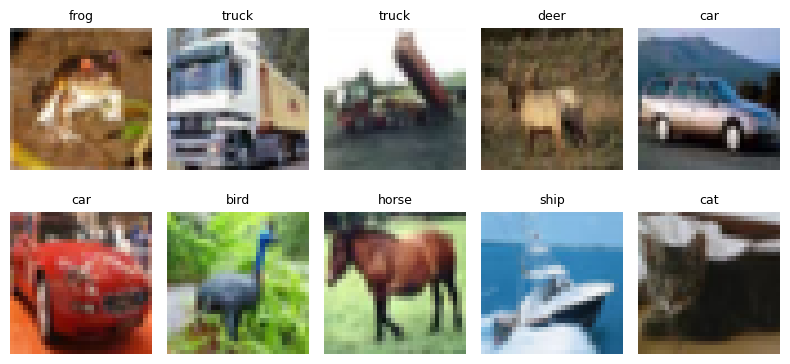

In [3]:
class_names = ['airplane','car','bird','cat','deer','dog','frog','horse','ship','truck']

plt.figure(figsize=(8,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i]], fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()


## 3) Build a fast `tf.data` pipeline (mini-batches + caching + prefetch)

In [4]:
# ------------------------------------------------------------
# Why tf.data?
# - Efficient input pipeline
# - Avoid Python bottlenecks
# - Better GPU utilization
#
# Key performance tricks:
# 1) .batch(BATCH_SIZE)  -> trains on mini-batches
# 2) .cache()            -> keeps data in memory after first epoch
# 3) .prefetch(AUTOTUNE) -> overlaps preprocessing with model execution
# ------------------------------------------------------------
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 256

train_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(50_000, seed=SEED)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTOTUNE)
)

print('Batches per full training epoch:', int(np.ceil(len(x_train)/BATCH_SIZE)))


Batches per full training epoch: 196


## 4) Model: ResNet-18-lite (Residual Blocks)

### Residual connection idea
**y = F(x) + x**

The skip connection helps gradients flow, making deep networks easier to train.

### Why “lite”?
For class demos, we reduce channels with `width_mult` to train faster.


In [5]:
from tensorflow.keras import layers

def conv3x3(filters, stride=1, name=None):
    """3x3 convolution with He initialization (good for ReLU)."""
    return layers.Conv2D(
        filters, 3, strides=stride, padding='same',
        use_bias=False, kernel_initializer='he_normal', name=name
    )

def basic_block(x, filters, stride=1, downsample=False, name='block'):
    """Basic residual block used in ResNet-18/34."""
    shortcut = x

    # 1) Conv -> BN -> ReLU
    x = conv3x3(filters, stride=stride, name=f'{name}_conv1')(x)
    x = layers.BatchNormalization(name=f'{name}_bn1')(x)
    x = layers.ReLU(name=f'{name}_relu1')(x)

    # 2) Conv -> BN
    x = conv3x3(filters, stride=1, name=f'{name}_conv2')(x)
    x = layers.BatchNormalization(name=f'{name}_bn2')(x)

    # If shape changes, match shortcut with a 1x1 projection
    if downsample:
        shortcut = layers.Conv2D(
            filters, 1, strides=stride, padding='same',
            use_bias=False, kernel_initializer='he_normal',
            name=f'{name}_proj_conv'
        )(shortcut)
        shortcut = layers.BatchNormalization(name=f'{name}_proj_bn')(shortcut)

    # Residual add + final ReLU
    x = layers.Add(name=f'{name}_add')([x, shortcut])
    x = layers.ReLU(name=f'{name}_out')(x)
    return x

def make_layer(x, filters, blocks, stride, name='layer'):
    """A ResNet stage: first block may downsample; others keep size."""
    x = basic_block(x, filters, stride=stride, downsample=(stride != 1), name=f'{name}_block1')
    for i in range(2, blocks + 1):
        x = basic_block(x, filters, stride=1, downsample=False, name=f'{name}_block{i}')
    return x

def build_resnet18_lite(input_shape=(32,32,3), num_classes=10, width_mult=0.5, seed=42):
    """ResNet-18-like model for CIFAR-10 with fewer channels for speed."""
    base = max(8, int(64 * width_mult))
    inputs = layers.Input(shape=input_shape, name='input')

    # Augmentation inside the model (fast on GPU)
    aug = tf.keras.Sequential([
        layers.RandomFlip('horizontal', seed=seed),
        layers.RandomTranslation(0.05, 0.05, fill_mode='reflect', seed=seed),
    ], name='augmentation')
    x = aug(inputs)

    # Stem
    x = layers.Conv2D(base, 3, strides=1, padding='same', use_bias=False,
                      kernel_initializer='he_normal', name='stem_conv')(x)
    x = layers.BatchNormalization(name='stem_bn')(x)
    x = layers.ReLU(name='stem_relu')(x)

    # ResNet stages [2,2,2,2]
    x = make_layer(x, base,   blocks=2, stride=1, name='layer1')
    x = make_layer(x, base*2, blocks=2, stride=2, name='layer2')
    x = make_layer(x, base*4, blocks=2, stride=2, name='layer3')
    x = make_layer(x, base*8, blocks=2, stride=2, name='layer4')

    # Classification head
    x = layers.GlobalAveragePooling2D(name='gap')(x)
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32', name='pred')(x)

    return tf.keras.Model(inputs, outputs, name=f'ResNet18_lite_w{width_mult}')

model = build_resnet18_lite(INPUT_SHAPE, NUM_CLASSES, width_mult=0.5, seed=SEED)
model.summary()


Model: "ResNet18_lite_w0.5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 32, 32, 3) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation        │ (None, 32, 32, 3) │          0 │ input[0][0]       │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 32, 32,    │        864 │ augmentation[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 32, 32,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_relu (ReLU)    │ (None, 32, 32,    │          0 │ stem_bn[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_conv1 │ (None, 32, 32,    │      9,216 │ stem_relu[0][0]   │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_bn1   │ (None, 32, 32,    │        128 │ layer1_block1_co… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_relu1 │ (None, 32, 32,    │          0 │ layer1_block1_bn… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_conv2 │ (None, 32, 32,    │      9,216 │ layer1_block1_re… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_bn2   │ (None, 32, 32,    │        128 │ layer1_block1_co… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_add   │ (None, 32, 32,    │          0 │ layer1_block1_bn… │
│ (Add)               │ 32)               │            │ stem_relu[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_out   │ (None, 32, 32,    │          0 │ layer1_block1_ad… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block2_conv1 │ (None, 32, 32,    │      9,216 │ layer1_block1_ou… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block2_bn1   │ (None, 32, 32,    │        128 │ layer1_block2_co… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block2_relu1 │ (None, 32, 32,    │          0 │ layer1_block2_bn… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block2_conv2 │ (None, 32, 32,    │      9,216 │ layer1_block2_re… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block2_bn2   │ (None, 32, 32,    │        128 │ layer1_block2_co… │
│ (BatchNormalizatio… │ 32)               │            │                 

 Total params: 2,802,410 (10.69 MB)

 Trainable params: 2,797,610 (10.67 MB)

 Non-trainable params: 4,800 (18.75 KB)

## 5) Compile: loss + optimizer + learning-rate scheduler

In [6]:
EPOCHS = 30
BASE_LR = 0.2

# Limit steps for speed in class demos
LIMIT_STEPS_PER_EPOCH = None  # set to None for full epoch

if LIMIT_STEPS_PER_EPOCH is None:
    steps_per_epoch = int(np.ceil(len(x_train) / BATCH_SIZE))
else:
    steps_per_epoch = LIMIT_STEPS_PER_EPOCH

print('Steps per epoch used:', steps_per_epoch)

# Cosine LR schedule
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=BASE_LR,
    decay_steps=steps_per_epoch * EPOCHS
)

# SGD + momentum
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)

# Loss (integer labels)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='acc')]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=8, restore_best_weights=True)
]


Steps per epoch used: 196


## 6) Train

In [7]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/30
196/196 - 45s - 231ms/step - acc: 0.2334 - loss: 2.2461 - val_acc: 0.2603 - val_loss: 2.1566
Epoch 2/30
196/196 - 16s - 83ms/step - acc: 0.4214 - loss: 1.5526 - val_acc: 0.2948 - val_loss: 2.1230
Epoch 3/30
196/196 - 16s - 84ms/step - acc: 0.5165 - loss: 1.3111 - val_acc: 0.4247 - val_loss: 1.6907
Epoch 4/30
196/196 - 16s - 84ms/step - acc: 0.5984 - loss: 1.1061 - val_acc: 0.5377 - val_loss: 1.3182
Epoch 5/30
196/196 - 17s - 85ms/step - acc: 0.6651 - loss: 0.9369 - val_acc: 0.5700 - val_loss: 1.3410
Epoch 6/30
196/196 - 17s - 86ms/step - acc: 0.7176 - loss: 0.8013 - val_acc: 0.6500 - val_loss: 1.0697
Epoch 7/30
196/196 - 20s - 104ms/step - acc: 0.7551 - loss: 0.6972 - val_acc: 0.6840 - val_loss: 0.9896
Epoch 8/30
196/196 - 20s - 104ms/step - acc: 0.7809 - loss: 0.6224 - val_acc: 0.7509 - val_loss: 0.7286
Epoch 9/30
196/196 - 17s - 85ms/step - acc: 0.8057 - loss: 0.5579 - val_acc: 0.7602 - val_loss: 0.7023
Epoch 10/30
196/196 - 17s - 85ms/step - acc: 0.8221 - loss: 0.5072 - v

## 7) Evaluate

In [8]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}')


Test loss: 0.5056
Test accuracy: 0.8651


## 8) Plot learning curves

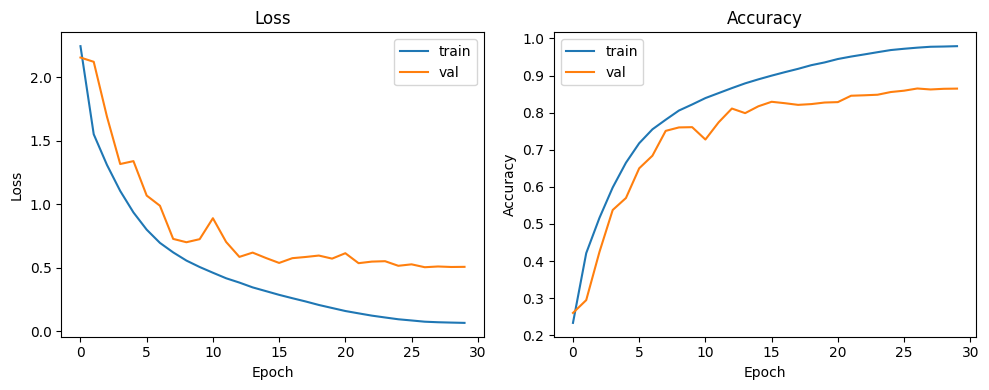

In [9]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## 9) Student exercises (optional)

Explore how to reduce overfitting.